#### Libraries

In [124]:
import pandas as pd
import numpy as np

In [125]:
RELATIVE_PATH_IN = "3. curated/"
RELATIVE_PATH_OUT = "4. out/"

## Pager

In [734]:
import pandas as pd
pager_raw_df = pd.read_csv("1. landing/2. csv/offers 2022 pager.csv")

In [735]:
new_column_names = ["_1", "_2", "uni offer", "prior qualification", "preference number", "first preference", "uni interview", 
                    "offer type", "gpa", "_3", "s1", "s2", "s3", "gamsat uni offer", "mcat", "score type",
                    "undergrad degree", "residency", "postgrad", "rural", "deakin bonus", "flinders applicant", "flinders program applicant",
                    "melbourne bonus", "_4"]

pager_raw_df.columns = new_column_names
pager_raw_df = pager_raw_df[[col for col in new_column_names if not "_" in col]]
pager_raw_df.shape

(432, 21)

In [736]:
situation_mask = ((pager_raw_df["offer type"] != "FFP") &
                  (pager_raw_df["score type"] == "GAMSAT") &
                  (pager_raw_df["residency"] == "Local") &
                  (pager_raw_df["rural"] == "No") &
                  (pager_raw_df["deakin bonus"] == 0) &
                  (pager_raw_df["melbourne bonus"] == "No"))

pager_df = pager_raw_df[situation_mask]
pager_df = pager_df.drop(columns = ["score type", "residency", "rural", "deakin bonus", "melbourne bonus"])

print(f"removed {situation_mask.sum()} records out of {pager_raw_df.shape[0]} records")

removed 177 records out of 432 records


In [737]:
mask = (pager_df["uni interview"] == "University of Melbourne") #| \
       #(pager_df["first preference"] == "University of Melbourne")

df = pager_df[mask]
df.loc[:, "offer"] = pager_df["uni offer"] == "University of Melbourne"
df.loc[:, "gamsat"] = df.apply(lambda x: (x["s1"] + x["s2"] + x["s3"]) / 3, axis=1)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_20032\2419873210.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mtp63\AppData\Local\Temp\ipykernel_20032\2419873210.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [738]:
df["uni interview"].value_counts()

uni interview
University of Melbourne    26
Name: count, dtype: int64

In [739]:
df = df[df["uni interview"] != "University of Queensland"]

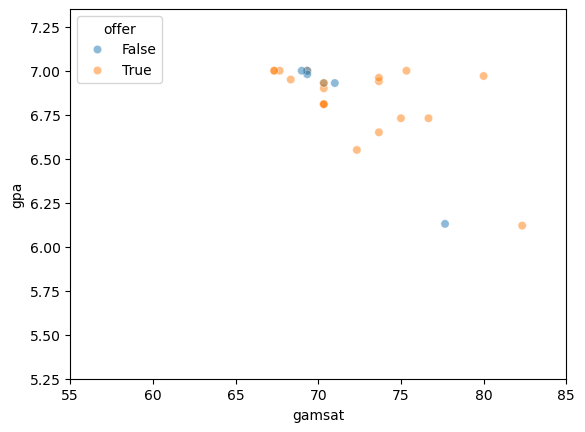

In [740]:
plot_gamsat_gpa(df, hue="offer", exp=False, combo=False)

# GEMSAS

In [126]:
MELB_NAME = 'The University of Melbourne'
UQ_METRO_NAME = 'The University of Queensland (Metro)'
UQ_RMP_NAME = 'The University of Queensland (RMP)'
DEAKIN_NAME = 'Deakin University'
GRIFFITH_NAME = 'Griffith University'

## Functions

### Filtering

In [127]:
def uni_mask(series, uni_name):
    return series.apply(lambda x: uni_name in x if isinstance(x, str) else False)

In [128]:
def filter_frame(df, uni=None, year="all", gamsat_range=None, gpa_range=None, 
                 success=None, marker=None,
                 anu="in"):
    # general use
    if (uni):
        df = df[uni_mask(df["interview uni"], uni) | uni_mask(df["offer uni"], uni)]
    if (year != "all"):
        df = df[df["year"] == year]
    if (gamsat_range):
        df = df[(gamsat_range[0] <= df["gamsat"]) & (df["gamsat"] <= gamsat_range[1])]
    if (gpa_range):
        df = df[(gpa_range[0] <= df["gpa"]) & (df["gpa"] <= gpa_range[1])]

    # for plotting
    if (success):
        df = df[df["success"] == success]
    if (marker):
        df = df[df["marker"] == marker]

    # special values
    if (anu != "in"):
        df = df[df["anu bonus"] == 0]
    
    return df

In [129]:
def filter_ranges(df):
    filter = ((0 <= df["gpa"]) &
              (df["gpa"] <= 7) &
              (0 <= df["gamsat"]) &
              (df["gamsat"] <= 100))

    return df[filter]

In [130]:
def filter_gam_values(x):
    if (not pd.notna(x)):
        return False
    if ("gamsat" in x):
        return False
    if (not "gam" in x):
        return False
    else:
        return True

In [131]:
def filter_gam(notes_series):
    return notes_series.apply(filter_gam_values)

### Plotting

In [132]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for intial legend
SUCCESS_PALETTE = {'accepted': 'darkorange', 'rejected': 'steelblue'}
SUCCESS_ORDER = ['accepted', 'rejected']
TYPE_MARKERS = {'CSP and BMP': 'o', 'CSP': 'X', 'BMP': 's', 'FFP': '*'}
TYPE_ORDER = ['CSP and BMP', 'CSP', 'BMP', 'FFP']

def plot_gamsat_gpa_basic(df, gamsat_col, gpa_col, hue, style):
    # plot
    ax = sns.scatterplot(
        data=df, x=gamsat_col, y=gpa_col, alpha=0.7,
        hue=hue, palette=SUCCESS_PALETTE, hue_order=SUCCESS_ORDER ,
        style=style, markers=TYPE_MARKERS, style_order=TYPE_ORDER
    )

    # get the counts of entrance and failures
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    
    # get the success stuff
    for curr_handle, curr_label in zip(handles, labels):
        if (curr_label in SUCCESS_ORDER):
            curr_count = filter_frame(df, success=curr_label).shape[0]
        elif (curr_label in TYPE_ORDER):
            curr_count = filter_frame(df, marker=curr_label).shape[0]
        else:
            continue        # this is the situation where this is category label
        
        # update the label and save
        curr_label = f"{curr_label} ({curr_count})"
        new_handles.append(curr_handle)
        new_labels.append(curr_label)
    
    # get the legend
    ax.legend(handles=new_handles, labels=new_labels, bbox_to_anchor=(1.31, 1), loc='upper right', 
                borderaxespad=0, title="results / offer")
    
    return ax

In [133]:
def plot_gamsat_gpa(df, gamsat_col="gamsat", gpa_col="gpa", hue=None, style=None,
                    path=None, return_csv=False, title=None,
                    year="all", success_type=None, exp=None, combo=None):
    
    # combo scores and such
    if (exp):
        df = df.copy()
        df[gpa_col] = df[gpa_col].apply(lambda x: np.exp(x))
    elif (combo):
        df = df.copy()
        df[gpa_col] = df[gpa_col].apply(lambda x: x / 7)
        df[gamsat_col] = df[gamsat_col].apply(lambda x: x / 100)
    
    # filtering
    if (year != "all"):
        df = df.copy()
        df = df[df["year"] == year]
    if (success_type):
        df = df[df["success"] == success_type]

    # check non empty
    if (df.empty):
        return None

    plt.figure(figsize=(9, 6))
    if (hue == "success" and style == "marker"):
        ax = plot_gamsat_gpa_basic(df, gamsat_col, gpa_col, hue, style)
    elif (hue == "success"):
        ax = sns.scatterplot(data=df, x=gamsat_col, y=gpa_col, alpha=0.7, style=style,
                             hue=hue, palette=SUCCESS_PALETTE, hue_order=SUCCESS_ORDER)
        ax.legend(bbox_to_anchor=(1.31, 1), loc='upper right', borderaxespad=0)
    else:
        ax = sns.scatterplot(data=df, x=gamsat_col, y=gpa_col, alpha=0.7, hue=hue, style=style)
        ax.legend(bbox_to_anchor=(1.31, 1), loc='upper right', borderaxespad=0)

    # Adjust layout to make room on the right without stretching the x-axis
    plt.subplots_adjust(right=0.75)  # Increase space on the right side

    if (combo):
        ax.set_xlim(0.55, 0.85)
        ax.set_ylim(0.75, 1.05)
    else:
        ax.set_xlim(55, 85)
        ax.set_ylim(5.25, 7.35)

    if (title):
        plt.title(title)

    if (not path):
        plt.show()
    else:
        plt.savefig(path)
    plt.close()

    if (return_csv):
        df = df.sort_values(by="combo score")
        return df
    else:
        return None


## GEMSAS Offers

In [134]:
offers = pd.read_csv(RELATIVE_PATH_IN + "offers.csv", index_col=0)

### Functions

##### Transform uni frame

In [135]:
def get_row_offer(series, uni):
    # get the uni index (only appears once)
    uni_value = series[uni_mask(series, uni)].values[0]
    uni_index = list(series.values).index(uni_value)

    # check if got offer
    if ("offer" in series.index[uni_index]):
        return "accepted"
    else:
        return "rejected"

In [136]:
def get_row_uni_info_offer(series, uni):
    # get the uni index (only appears once)
    uni_value = series[uni_mask(series, uni)].values[0]
    uni_index = list(series.values).index(uni_value)

    # get the next value
    uni_info = list(series.values)[uni_index+1: uni_index+5]

    # remove the place type
    uni_info.pop(2)

    if (len(uni_info) != 3):
        raise ValueError(f"uni_info is of size {len(uni_info)} but should be of size 3")
    
    return uni_info

In [137]:
def get_uni_gpa_offer(df, uni, columns="subset"):
    # filter for the uni
    df_filt = df[uni_mask(df["offer uni"], uni) | uni_mask(df["interview uni"], uni)]

    # get each uni gpa
    df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)

    # get the combo score
    df_filt["combo score"] = df_filt["gpa"] / 7 + df_filt["gamsat"] / 100

    # get the interview offers
    df_filt.loc[:, "success"] = df_filt.apply(lambda x: get_row_offer(x, uni), axis=1)
    
    # get the column of 
    if (columns == "subset"):
        df_filt = df_filt[["offer uni", "interview uni", "gpa", "gamsat", "preference", "combo score", "offer uni place type", 
                           "places selected", "marker", "success", 
                           "interview opinion discrete", "interview prep hours discrete",
                           "anu bonus", "notes", "year"]]
    # otherwise use all columns

    # return the df
    return df_filt

##### Plotting

In [138]:
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

def plot_gamsat_gpa_3d(df, third_column, gamsat_col="gamsat", gpa_col="gpa", hue="success", discrete_hue=True, year=False):
    if (year):
        df = filter_frame(df, year=year)
    
    # filter the frame of na columns
    df = df[df[third_column].notna()]

    # get the hue discrete
    if discrete_hue:
        le = LabelEncoder()
        df[hue] = le.fit_transform(df[hue].values)

    # Create a 3D scatter plot with Plotly
    fig = px.scatter_3d(df, x=gamsat_col, y=gpa_col, z=third_column, color=hue, opacity=0.8)

    fig.update_layout(scene=dict(
                        xaxis=dict(title='gamsat', range=[65, 85], autorange='reversed'),
                        yaxis=dict(title='gpa', range=[5.8, 7.2]),
                        zaxis=dict(title='interview opinion')
                        ))

    # Show interactive plot
    fig.show()

### Filter the situation

In [139]:
situation_mask = ((offers["rurality"] == "Non-Rural") &
                  (offers["deakin bonus"] == 0) &
                  (~filter_gam(offers["notes"])) &
                  (offers["offer uni place type"] != "FFP") &
                  ((offers["uq rmp tier"].isna()) |
                   (offers["uq rmp tier"] == "Tier 3")))


offers_filt = offers[situation_mask]
offers_filt.shape[0]

477

In [140]:
offers.to_csv(RELATIVE_PATH_OUT + "offers.csv")
offers.to_csv(RELATIVE_PATH_OUT + "offers filtered.csv")

### Non plotting EDA

#### Measuring Inbalance

In [65]:
"""""
(FOR 2023)
1. offers to interview ratio (multiply application numbers)
2. interview to offers ratio (once you get an interview according to this)
3. overall acceptance rate, putting the preference down
4. percentage of people from the uni
"""
def get_ratio(df, uni_name, uni_name_short):
    # year 2023, and either accepted or rejected from melbourne uni
    uni_offer_raw = df[(uni_mask(df["interview uni"], uni_name) | uni_mask(df["offer uni"], uni_name)) & (df["year"] == 2023)]

    # interviewing somewhere else THEN getting into melbourne
    offer_uni_interview_away = uni_offer_raw[(~uni_mask(uni_offer_raw["interview uni"], uni_name)) & (uni_offer_raw["interview uni"].notna())].shape[0]

    # rejected from melbourne uni
    offer_none_or_away_interview_uni = uni_offer_raw[uni_mask(uni_offer_raw["interview uni"], uni_name)].shape[0]

    # number of rejections in missing other rejections
    offer_none_or_away_interview_away = uni_mask(df["other rejections"], uni_name_short).sum()
    #print(offer_none_or_away_interview_away)

    # number of accepted offers
    offer_uni = uni_offer_raw[uni_mask(uni_offer_raw["offer uni"], uni_name)].shape[0]

    # interviewing unimelb, getting in unimelb
    offer_uni_interview_uni = offer_uni - offer_uni_interview_away

    # return the offers / interviews AND failure rate
    triple = [1 / (offer_uni/(offer_uni_interview_uni + offer_none_or_away_interview_uni)),
              offer_uni_interview_uni/(offer_uni_interview_uni + offer_none_or_away_interview_uni),
              offer_uni/(uni_offer_raw.shape[0] + offer_none_or_away_interview_away),
              offer_uni_interview_uni/offer_uni]
    
    # roun and return
    triple = [round(x, 3) for x in triple]
    return triple

In [66]:
get_ratio(offers, MELB_NAME, "UniMelb")


[1.29, 0.742, 0.52, 0.957]

In [67]:
get_ratio(offers, UQ_METRO_NAME, "UQ")

[1.643, 0.609, 0.179, 1.0]

In [68]:
get_ratio(offers, UQ_RMP_NAME, "UQ")

[1.262, 0.736, 0.378, 0.929]

In [69]:
get_ratio(offers, DEAKIN_NAME, "Deakin")

[1.0, 0.712, 0.416, 0.712]

In [70]:
get_ratio(offers, GRIFFITH_NAME, "Griffith")

[1.045, 0.739, 0.328, 0.773]

### Plotting

#### Basic plots

In [141]:
#def get_unique_unis(series):
#    uniq_list = series.unique()
#    return list(set([x.split(" (")[0] for x in uniq_list if not pd.isna(x)]))

def get_unique_unis(series):
    uniq_list = series.unique()
    return [x for x in uniq_list if not pd.isna(x)]

In [142]:
MEGA_SHEET_NAME = "all offers"

def get_basic(df, relative_path_out):
    # get the unique unis
    uniq_unis = get_unique_unis(df["offer uni"])

    with pd.ExcelWriter(f"{relative_path_out}/{MEGA_SHEET_NAME}.xlsx", engine='openpyxl') as writer:
        for uni_name in uniq_unis:
            # filter for the uni
            uni_offer = get_uni_gpa_offer(df, uni_name)

            for year in [2022, 2023, "all"]:
                # get the filtered frame
                filt_uni_offer = filter_frame(uni_offer, year=year)

                # get the file name
                file_name = f"{uni_name} {year}"

                # get the plot
                curr_df = plot_gamsat_gpa(
                    filt_uni_offer, hue="success", style="marker",
                    title=f"{uni_name} {year} ({filt_uni_offer.shape[0]})",
                    path=f"{relative_path_out}/{file_name}",
                    return_csv=True
                )
                
                # check all columns weren't removed
                if (not curr_df is None and not curr_df.empty):
                    curr_df.to_excel(writer, sheet_name=file_name, index=False)

In [143]:
def get_basic_anu(df, relative_path_out):
    # get the unique unis
    uniq_unis = get_unique_unis(df["offer uni"])

    with pd.ExcelWriter(f"{relative_path_out}/{MEGA_SHEET_NAME}.xlsx", engine='openpyxl') as writer:
        for uni_name in uniq_unis:
            uni_offer = get_uni_gpa_offer(df, uni_name)

            for anu_value in ["out", "in"]:
                for year in [2022, 2023, "all"]:
                    # get the filtered frame
                    filt_uni_offer = filter_frame(uni_offer, year=year, anu=anu_value)

                    # get the file name
                    file_name = f"{uni_name} {year} anu {anu_value}"

                    # get the plot
                    curr_df = plot_gamsat_gpa(
                        filt_uni_offer, hue="success", style="marker",
                        title=f"{uni_name} {year} anu {anu_value} ({filt_uni_offer.shape[0]})",
                        path=f"{relative_path_out}/{file_name}",
                        return_csv=True
                    )

                    # check all columns weren't removed
                    if (not curr_df is None and not curr_df.empty):
                        curr_df.to_excel(writer, sheet_name=file_name, index=False)

In [144]:
#melb_offer = get_uni_gpa_offer(offers_filt, "The University of Melbourne")

In [145]:
relative_path_out = RELATIVE_PATH_OUT + "offers basic"
get_basic(offers_filt, relative_path_out)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\1611296466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\1611296466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipyk

In [146]:
relative_path_out = RELATIVE_PATH_OUT + "offers basic anu"
get_basic_anu(offers_filt, relative_path_out)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\1611296466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\1611296466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipyk

#### Histograms

In [147]:
COMBO_BINS = [round(1.54 + x*0.02, 3) for x in range(16+1)]

def get_histogram_offer(df, uni_name, relative_path, csv=True):
    # get the filtered df
    uni_offer = get_uni_gpa_offer(df, uni_name)
    uni_offer_success = uni_offer[uni_offer["success"] == "accepted"]

    for year in [2022, 2023, False]:
        uni_offer_success_filt = filter_frame(uni_offer_success, year=year)

        if (uni_offer_success_filt.empty):
            continue

        # get the histogram
        plt.hist(uni_offer_success_filt["combo score"].values, bins=COMBO_BINS, alpha=0.7)

        # git information
        plt.xlabel("combo score binned")
        plt.ylabel("frequency")

        if (not year):
            year = "all"

        plt.title(f"{uni_name} {year} ({uni_offer_success_filt.shape[0]})")

        plt.savefig(f"{relative_path}/{uni_name} {year}.png")

        if (csv):
            uni_offer_success_filt.to_csv(f"{relative_path}/{uni_name} {year}.csv", index=False)

        plt.close()

In [148]:
uniq_unis = get_unique_unis(offers["offer uni"])
relative_path_out = RELATIVE_PATH_OUT + "offers histograms"

offers_filt_no_anu = filter_frame(offers_filt, anu="out")

for uni in uniq_unis:
    get_histogram_offer(offers_filt_no_anu, uni, relative_path_out, csv=False)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\1611296466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\1611296466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipyk

#### Explore

In [47]:
uq_offer = get_uni_gpa_offer(offers_filt, UQ_NAME)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_3436\492360366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykernel_3436\492360366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykerne

In [62]:
filter_frame(offers, year=2022)["offer uni"].value_counts()

offer uni
The University of Melbourne               70
Deakin University                         52
Griffith University                       40
The University of Notre Dame Sydney       25
The University of Western Australia       21
The University of Queensland (RMP)        19
The University of Notre Dame Fremantle    16
The University of Wollongong              15
Australian National University            14
Macquarie University                      12
The University of Queensland (Metro)      10
Name: count, dtype: int64

In [24]:
melb_offer = get_uni_gpa_offer(offers_filt, MELB_NAME)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_20608\492360366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykernel_20608\492360366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_offer(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipyker

##### Basic

C:\Users\mtp63\AppData\Local\Temp\ipykernel_20032\492360366.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mtp63\AppData\Local\Temp\ipykernel_20032\492360366.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mtp63\AppData\Local\Temp\ipykernel_20032\492360366.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

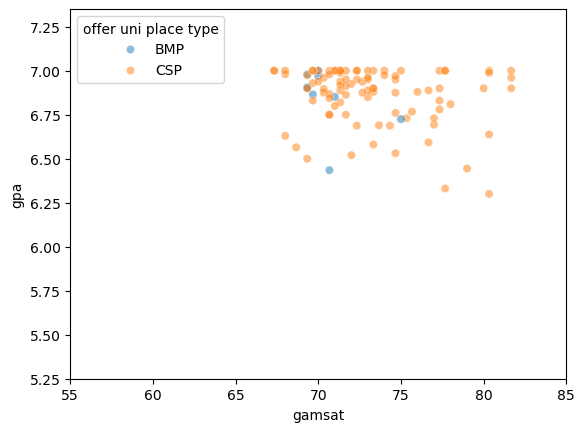

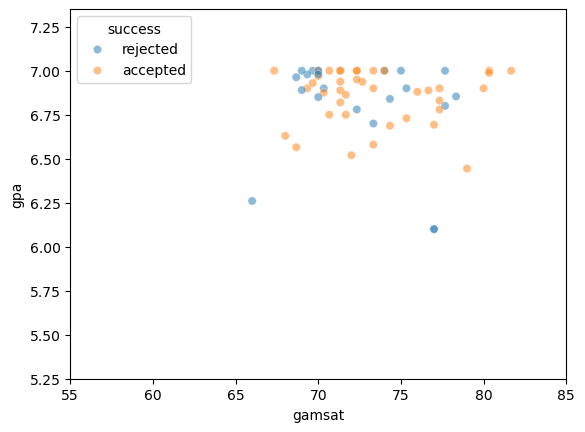

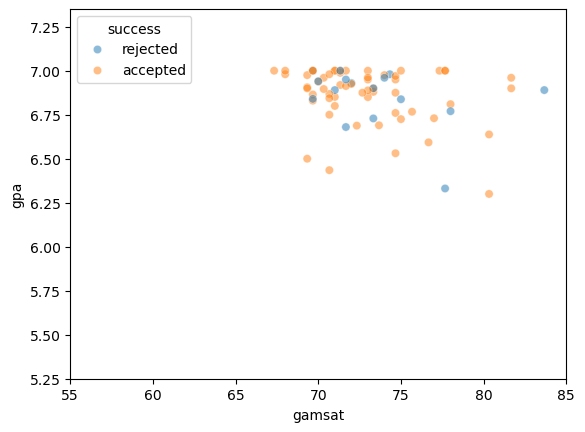

In [517]:
plot_gamsat_gpa(melb_offer, hue="offer uni place type")
plot_gamsat_gpa(melb_offer, hue="success", year=2022)
plot_gamsat_gpa(melb_offer, hue="success", year=2023)

##### gamsat gpa + 3rd column

In [492]:
plot_gamsat_gpa_3d(melb_offer, "interview prep hours discrete", year=2023)

In [487]:
plot_gamsat_gpa_3d(melb_offer, "interview opinion discrete", year=2022)
plot_gamsat_gpa_3d(melb_offer, "interview opinion discrete", year=2023)

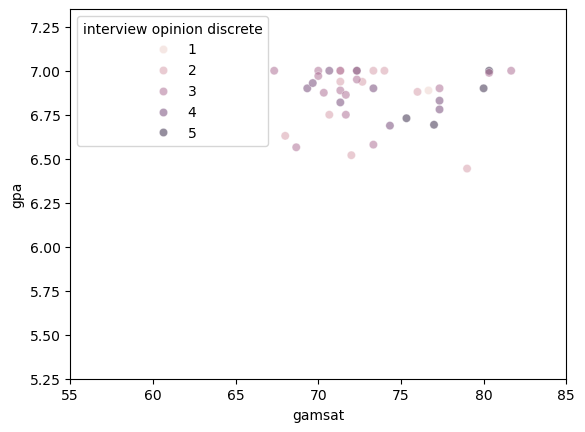

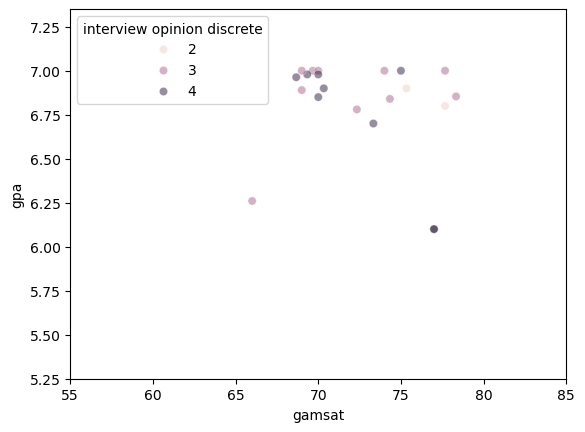

In [496]:
plot_gamsat_gpa(melb_offer, hue="interview opinion discrete", year=2022, success_type="accepted")
plot_gamsat_gpa(melb_offer, hue="interview opinion discrete", year=2022, success_type="rejected")

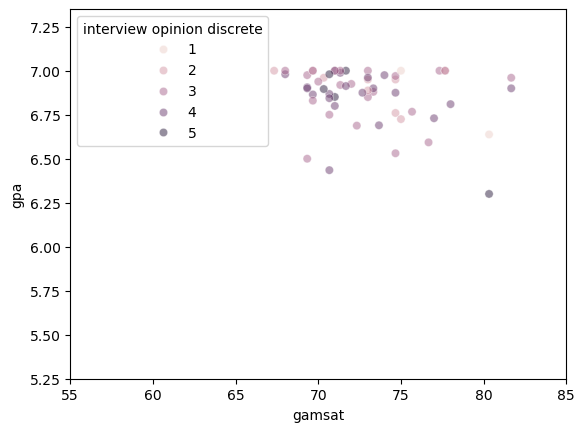

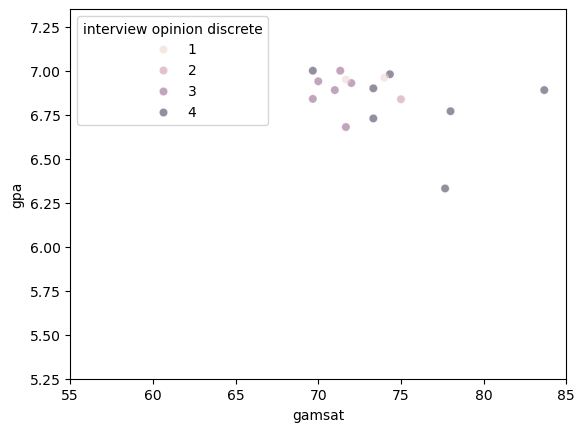

In [500]:
plot_gamsat_gpa(melb_offer, hue="interview opinion discrete", year=2023, success_type="accepted")
plot_gamsat_gpa(melb_offer, hue="interview opinion discrete", year=2023, success_type="rejected")

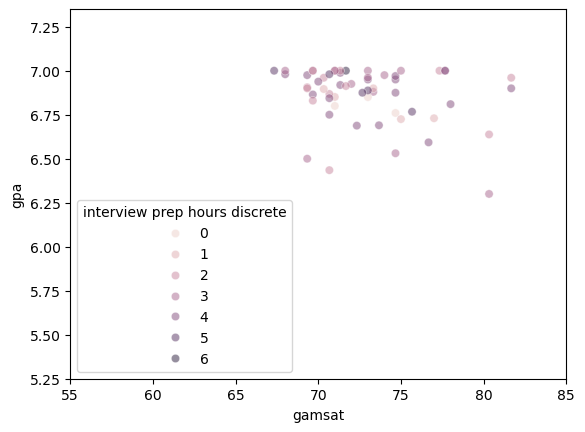

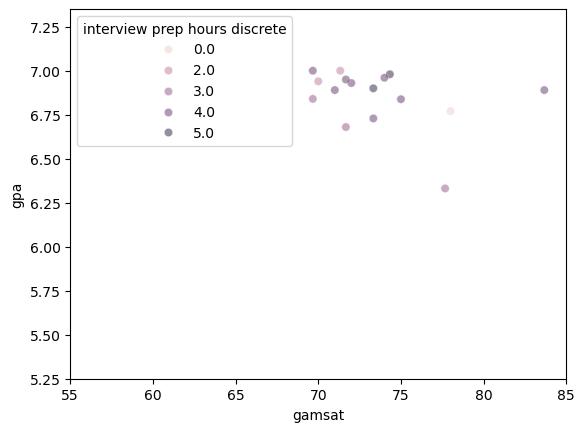

In [503]:
plot_gamsat_gpa(melb_offer, hue="interview prep hours discrete", year=2023, success_type="accepted")
plot_gamsat_gpa(melb_offer, hue="interview prep hours discrete", year=2023, success_type="rejected")

##### Combo score

In [564]:
combo_quantile_success = melb_offer[melb_offer["success"] == "accepted"]["combo score"].quantile([0.05, 0.1, 0.25])
combo_quantile_reject = melb_offer[melb_offer["success"] == "rejected"]["combo score"].quantile([0.05, 0.1, 0.25])

combo_quantile_success.name = "accepted"
combo_quantile_reject.name = "rejected"

pd.concat([combo_quantile_success, combo_quantile_reject], axis=1)

,accepted,rejected
0.05,1.668024,1.641429
0.10,1.673333,1.672700
0.25,1.687675,1.689048


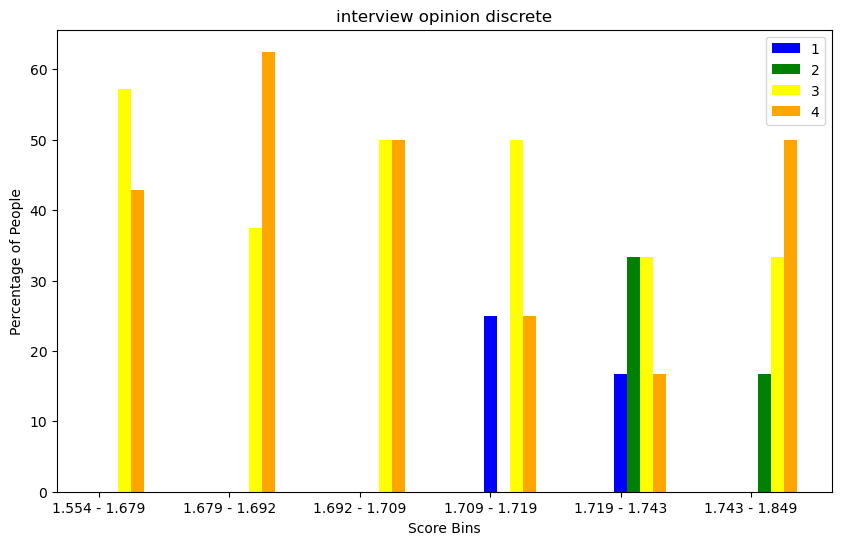

In [587]:
COLUMN_INTEREST = 'interview opinion discrete'

# get the bins
melb_offer['combo score binned'], bins = pd.qcut(melb_offer['combo score'], q=6, labels=False, retbins=True)

# re change the bins
bins = [round(x, 3) for x in bins]

# Create a pivot table to calculate the counts for each bin
pivot = melb_offer[melb_offer["success"] == "rejected"].groupby(['combo score binned', COLUMN_INTEREST]).size().unstack(fill_value=0)

# Calculate total counts and percentages
pivot['total'] = pivot.sum(axis=1)

# number of values
num_values = pivot.shape[1] - 1

for i in range(num_values):
    pivot[f'{i}'] = (pivot.iloc[:, i] / pivot['total']) * 100  # % got in

# Plotting the histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Plot two bars: one for 'got in' and one for 'not got in'
width = 0.1  # Width of the bars
x = range(len(pivot))  # X locations for the bars

# Bar positions
COLORS = ["blue", "green", "yellow", "orange", "red", "purple", "pink"]
for i in range(num_values):
    bar_positions = [j + (i * width) for j in x]  # Shift each bar to the right based on its index
    _ = ax.bar(bar_positions, pivot[f'{i}'], width, label=pivot.columns[i], color=COLORS[i])

# Add labels and title
ax.set_xlabel('Score Bins')
ax.set_ylabel('Percentage of People')
ax.set_title(COLUMN_INTEREST)
ax.set_xticks(x)  # Set x ticks to the positions of the bars

# Set x tick labels to the score bin edges
ax.set_xticklabels([f"{bins[i]} - {bins[i + 1]}" for i in range(len(bins) - 1)])  # Create ranges

ax.legend()

plt.show()

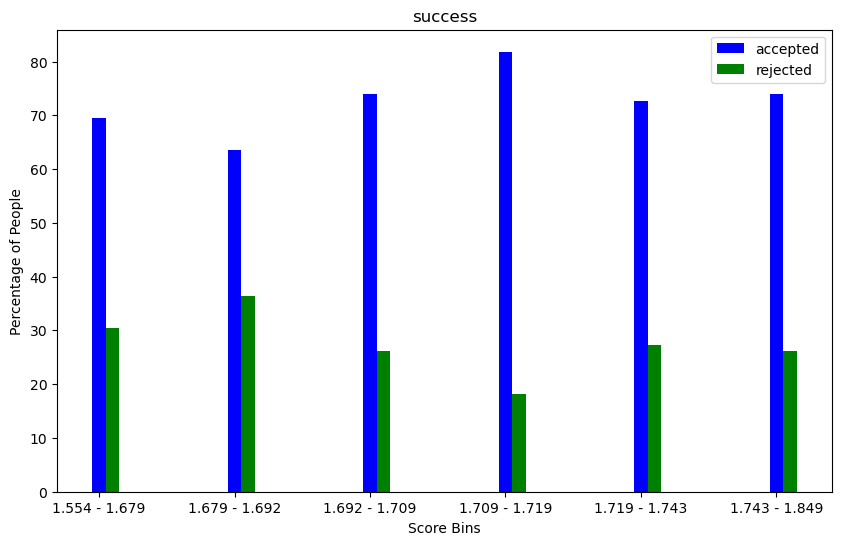

In [585]:
COLUMN_INTEREST = 'success'

# get the bins
melb_offer['combo score binned'], bins = pd.qcut(melb_offer['combo score'], q=6, labels=False, retbins=True)

# re change the bins
bins = [round(x, 3) for x in bins]

# Create a pivot table to calculate the counts for each bin
pivot = melb_offer.groupby(['combo score binned', COLUMN_INTEREST]).size().unstack(fill_value=0)

# Calculate total counts and percentages
pivot['total'] = pivot.sum(axis=1)

# number of values
num_values = pivot.shape[1] - 1

for i in range(num_values):
    pivot[f'{i}'] = (pivot.iloc[:, i] / pivot['total']) * 100  # % got in

# Plotting the histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Plot two bars: one for 'got in' and one for 'not got in'
width = 0.1  # Width of the bars
x = range(len(pivot))  # X locations for the bars

# Bar positions
COLORS = ["blue", "green", "yellow", "orange", "red", "purple", "pink"]
for i in range(num_values):
    bar_positions = [j + (i * width) for j in x]  # Shift each bar to the right based on its index
    _ = ax.bar(bar_positions, pivot[f'{i}'], width, label=pivot.columns[i], color=COLORS[i])

# Add labels and title
ax.set_xlabel('Score Bins')
ax.set_ylabel('Percentage of People')
ax.set_title(COLUMN_INTEREST)
ax.set_xticks(x)  # Set x ticks to the positions of the bars

# Set x tick labels to the score bin edges
ax.set_xticklabels([f"{bins[i]} - {bins[i + 1]}" for i in range(len(bins) - 1)])  # Create ranges

ax.legend()

plt.show()

## GEMSAS Interview

### reading in and filtering

In [149]:
# read in
interview = pd.read_csv(f"{RELATIVE_PATH_IN}/interview.csv", index_col=0)

# drop unncessary columns
interview.drop(columns=["timestamp", "uw gamsat", "w gamsat", "duplicates?", "location", "outlier"], inplace=True)

In [150]:
interview.columns

Index(['rurality', 's1 score', 's2 score', 's3 score', 'deakin bonus',
       'anu bonus', 'mq bonus', 'notes', 'interview?', 'interview uni',
       'interview uni gpa', 'interview uni gamsat', 'pref 1 uni', 'pref 1 gpa',
       'pref 1 gamsat', 'pref 2 uni', 'pref 2 gpa', 'pref 2 gamsat',
       'pref 3 uni', 'pref 3 gpa', 'pref 3 gamsat', 'pref 4 uni', 'pref 4 gpa',
       'pref 4 gamsat', 'pref 5 uni', 'pref 5 gpa', 'pref 5 gamsat',
       'pref 6 uni', 'pref 6 gpa', 'pref 6 gamsat', 'year', 'uq tier',
       'casper quartile', 'deakin tier', 'unimelb gam', 'undf bonuses',
       'unds bonuses', 'uow bonuses'],
      dtype='object')

In [151]:
interview["uq tier"].value_counts()

uq tier
Tier 3                92
Tier 2                14
Tier 1 (DD RMP)        4
Tier 1 (CQ/WB)         4
Tier 1 (CQ-WB RMP)     3
Tier 1 (DD)            1
Name: count, dtype: int64

In [152]:
situation_mask = ((interview["rurality"] == "Non-Rural") &
                  (interview["deakin bonus"] == 0) &
                  (~uni_mask(interview["deakin tier"], "tier")) &
                  (interview["unimelb gam"] != "Yes") &
                  ((interview["uq tier"].isna()) |
                   (interview["uq tier"] == "Tier 3")))

interview_filt = interview[situation_mask]
interview_filt.shape[0]

955

In [153]:
interview.to_csv(RELATIVE_PATH_OUT + "interview.csv")
interview_filt.to_csv(RELATIVE_PATH_OUT + "interview filtered.csv")

### Functions

#### Filtering

In [154]:
def get_row_interview(series, uni):
    # get the uni index (only appears once)
    uni_value = series[uni_mask(series, uni)].values[0]
    uni_index = list(series.values).index(uni_value)

    # check if got offer
    if ("interview" in series.index[uni_index]):
        return "accepted"
    else:
        return "rejected"

In [155]:
PREFERENCE_COLUMNS = [f"pref {i+1} uni" for i in range(6)]

def get_row_preference_interview(series, uni):
    # get the uni index (only appears once)
    uni_value = series[uni_mask(series, uni)].values[0]
    uni_index = list(series.values).index(uni_value)
    uni_index_name = list(series.index)[uni_index]

    # if preference in there, can append
    if ("pref" in uni_index_name):
        return int(uni_index_name[5])
    
    # see the number of preferences gone through
    perferences_done = series.loc[PREFERENCE_COLUMNS].notna().sum()

    return perferences_done + 1

In [156]:
def get_row_uni_info_interview(series, uni):
    # get the uni index (only appears once)
    uni_value = series[uni_mask(series, uni)].values[0]
    uni_index = list(series.values).index(uni_value)

    # get the next value
    uni_info = list(series.values)[uni_index+1: uni_index+3]
    uni_info = [float(x) for x in uni_info]

    # get the preference
    uni_info.append(get_row_preference_interview(series, uni))
    
    return uni_info

In [157]:
PREFERENCE_COLUMNS = [f"pref {i+1} uni" for i in range(6)]

def mask_columns_interview(df, uni, preference_only=False, exact=False):
    if (not preference_only and not exact):
        mask = uni_mask(df["interview uni"], uni)
    elif (not preference_only):
        mask = df["interview uni"] == uni
    else:
        mask = pd.Series(data=True, index=df.index)

    for preference_col in PREFERENCE_COLUMNS:
        if (not exact):
            mask = mask | (uni_mask(df[preference_col], uni))
        else:
            mask = mask | (df[preference_col] == uni)

    return mask

In [158]:
def get_uni_gpa_interview(df, uni, columns="subset", exact=False):
    # filter for the uni
    df_filt = df[mask_columns_interview(df, uni, exact=exact)]

    # get each uni gpa
    df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_interview(x, uni), axis=1).apply(pd.Series)

    # get the combo score
    df_filt["combo score"] = df_filt["gpa"] / 7 + df_filt["gamsat"] / 100

    # get the interview offers
    df_filt.loc[:, "success"] = df_filt.apply(lambda x: get_row_interview(x, uni), axis=1)
    
    # get the column of 
    if (columns == "subset"):
        df_filt = df_filt[["interview uni", "gpa", "gamsat", "preference", "combo score", "success", 
                           "anu bonus", "uq tier", "year", "unimelb gam", "undf bonuses", "unds bonuses", "notes"]]
    # otherwise use all columns

    # return the df
    return df_filt

### Execution

#### Basic

In [159]:
def get_basic_interview(df, uni_name, relative_path_out):
    uni_interview = get_uni_gpa_interview(df, uni_name, exact=True)

    plot_gamsat_gpa(uni_interview, hue="success", year=2022, path=f"{relative_path_out}/{uni_name} 2022", title=f"{uni_name} 2022 ({filter_frame(uni_interview, year=2022).shape[0]})")
    plot_gamsat_gpa(uni_interview, hue="success", year=2023, path=f"{relative_path_out}/{uni_name} 2023", title=f"{uni_name} 2023 ({filter_frame(uni_interview, year=2023).shape[0]})")
    plot_gamsat_gpa(uni_interview, hue="success", year=2024, path=f"{relative_path_out}/{uni_name} 2024", title=f"{uni_name} 2024 ({filter_frame(uni_interview, year=2024).shape[0]})")

In [160]:
uniq_unis = get_unique_unis(interview_filt["interview uni"])
relative_path_out = RELATIVE_PATH_OUT + "interview basic"

for uni in uniq_unis:
    get_basic_interview(interview_filt, uni, relative_path_out)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\35302099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_interview(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\35302099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_interview(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\

#### Histograms

In [161]:
COMBO_BINS = [round(1.54 + x*0.02, 3) for x in range(16+1)]

def get_histogram_interview(df, uni_name, relative_path, csv=True):
    # get the filtered df
    uni_interview = get_uni_gpa_interview(df, uni_name, exact=True)
    uni_interview_success = uni_interview[uni_interview["success"] == "accepted"]

    for year in [2022, 2023, 2024, "all"]:
        uni_interview_success_filt = filter_frame(uni_interview_success, year=year)

        if (uni_interview_success_filt.empty):
            continue

        # get the histogram
        plt.hist(uni_interview_success_filt["combo score"].values, bins=COMBO_BINS, alpha=0.7)

        # git information
        plt.xlabel("combo score binned")
        plt.ylabel("frequency")
        plt.title(f"{uni_name} {year} ({uni_interview_success_filt.shape[0]})")

        plt.savefig(f"{relative_path}/{uni_name} {year}.png")

        if (csv):
            uni_interview_success_filt.to_csv(f"{relative_path}/{uni_name} {year}.csv", index=False)

        plt.close()

In [162]:
uniq_unis = get_unique_unis(interview_filt["interview uni"])
relative_path_out = RELATIVE_PATH_OUT + "interview histograms"

for uni in uniq_unis:
    get_histogram_interview(interview_filt, uni, relative_path_out, csv=False)

C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\35302099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_interview(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\ipykernel_23940\35302099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt[["gpa", "gamsat", "preference"]] = df_filt.apply(lambda x: get_row_uni_info_interview(x, uni), axis=1).apply(pd.Series)
C:\Users\mtp63\AppData\Local\Temp\

## Copying Files

In [163]:
import shutil
import os

def combine_dirs(interview_dir, offer_dir, out_dir):
    # copy interview first
    for file_name in os.listdir(interview_dir):
        if (not file_name.endswith(".png")):
            continue

        old_path = f"{interview_dir}/{file_name}"
        new_path = f"{out_dir}/{file_name[:-4]} interview.png"
        shutil.copy2(old_path, new_path)

    # copy the offer files
    for file_name in os.listdir(offer_dir):
        if (not file_name.endswith(".png")):
            continue

        old_path = f"{offer_dir}/{file_name}"
        new_path = f"{out_dir}/{file_name[:-4]} offer.png"
        shutil.copy2(old_path, new_path)

In [164]:
interivew_dir = RELATIVE_PATH_OUT + "interview basic"
offer_dir = RELATIVE_PATH_OUT + "offers basic"
out_dir = RELATIVE_PATH_OUT + "all basic"

combine_dirs(interivew_dir, offer_dir, out_dir)

In [165]:
interivew_dir = RELATIVE_PATH_OUT + "interview histograms"
offer_dir = RELATIVE_PATH_OUT + "offers histograms"
out_dir = RELATIVE_PATH_OUT + "all histograms"

combine_dirs(interivew_dir, offer_dir, out_dir)